## Notebook Two
In this notebook we use YouTube's API to find data about the most popular or trending videos on YouTube. Due to limitations imposed by Youtube, we can only gather information on the current top 200 videos. We start by importing all modules, packages, and libraries that will be needed.

In [1]:
import requests
import json
from requests_oauthlib import OAuth2Session
import pandas as pd
import matplotlib.pyplot as plt

Here we open the file 'dump.bin', where all the information we created in the first notebook was stored for later use. We open the file and use the json.load method to read the json object into a dictionary. From here we then create a variable for each entry in the dictionary

In [2]:
f = open('dump.bin', 'r')
d = json.load(f)
f.close()

state = d['state']
client_id = d['client_id']
client_secret = d['client_secret']
scope = d['scope']
code = d['code']
token = d['token']
refresh_token = d['refresh_token']
token_uri = d['token_uri']
redirect = d['redirect']
auth_uri = d['auth_uri']

In [3]:
# URLs
channels_URL = 'https://www.googleapis.com/youtube/v3/channels'
videos = 'https://www.googleapis.com/youtube/v3/videos'

Above is the creation of the different URL's that, along with some parameters, we will use to request data from the API. Below we create an OAuth2Session so that we can gain access to the API.

In [4]:
session = OAuth2Session(client_id, scope=scope, redirect_uri=redirect)

In [5]:
def get(url, params, token):
    '''
    This function preforms the request from the API. Depending on the status code that is returned it will either print
    a status code indicating success or an error. If the token has expired, the funciton will print "Error 401. Refreshing token..."
    and then refreshes the token and re-executes the request.
    The return value is the response object from the request.
    '''
    r = None

    r = requests.get(url, params)

    ### Check for errors
    if r.status_code == 400:
        print("Error 400: Bad request. Although this should work, it does not")
        r = None
    if r.status_code == 401:
        print('Error 401. Refreshing token...')
        #refresh token 
        
        refresh_url = token_uri
        token = session.refresh_token(refresh_url, 
                                      refresh_token = refresh_token,
                                      client_id=client_id,
                                      client_secret=client_secret)
        params['access_token'] = token['access_token']
        r = requests.get(url, params)
        print(r.status_code)
    if r.status_code == 403:
        r = None
    if r.status_code == 404:
        print("Error 404: The channel was not found.")
        r = None
               
    return r

Below we initialize four different dictionaries that will be made into pandas data frames. The information that is gathered from our requests will fill the corresponding dictionaries.

In [6]:
snippet = {'v_id':[], 'channel_id':[], 'channel_title':[], 'published_at':[], 'v_title':[], 'v_desc':[]}
tags = {'v_id':[], 'tag':[]}
channels = {'channel_id':[], 'country':[], 'subscribers':[], 'channel_title':[], 'num_videos':[]}
stats = {'v_id':[], 'likes':[], 'dislikes':[], 'views':[], 'comments':[]}
content_details = {'v_id':[],'caption':[], 'definition':[], 'duration':[]}

params = {}
params['part'] = 'snippet,statistics,contentDetails'
params['chart'] = 'mostPopular'
params['access_token'] = token['access_token']
params['mine'] = True
params['maxResults'] = 50
params['pageToken'] = ''

num_pages = 4

Here we actually gather the data, using the get method defined above, through a series of loops. We are gathering data from the top 200 most popular/trending videos at this current time. The code below uses the page token to loop and gather information from the multiple pages of results that are returned.

In [7]:
for i in range(0,num_pages):
    r = get(videos, params, token)
    retval = json.loads(r.text)
  
    if retval != None:
        for j in retval['items']:
            ### Snippet
            s = j['snippet']
            snippet['v_id'].append(j['id'])
            snippet['channel_id'].append(s['channelId'])
            snippet['channel_title'].append(s['channelTitle'])
            snippet['published_at'].append(s['publishedAt'])
            snippet['v_title'].append(s['title'])
            snippet['v_desc'].append(s['description'])

            ### Tags
            try:
                t = s['tags']
                for k in t:
                    tags['v_id'].append(j['id'])
                    tags['tag'].append(k)
            except:
                pass

            ### Statistics

            s = j['statistics']
            stats['v_id'].append(j['id'])
            try:
                stats['likes'].append(int(s['likeCount']))
            except:
                stats['likes'].append(None)
            try:
                stats['dislikes'].append(int(s['dislikeCount']))
            except:
                stats['dislikes'].append(None)
            try:
                stats['comments'].append(int(s['commentCount']))
            except:
                stats['comments'].append(None)
            stats['views'].append(int(s['viewCount']))

            ### Content Details
            s = j['contentDetails']
            content_details['v_id'].append(str(j['id']))
            content_details['caption'].append(bool(s['caption']))
            content_details['definition'].append(s['definition'])
            content_details['duration'].append(s['duration'])

    ### Get next page
    try:
        params['pageToken'] = retval['nextPageToken']
    except:
        break
    

Error 401. Refreshing token...
200


In the cell above, we populate the dictionaries snippet, tags, statistics, and content_details. Below is the data gathering and populating for the dictionary channels. These are separtated because they use different urls.

In [11]:
chan_parm = {}
chan_parm['part'] = 'snippet,statistics'
chan_parm['id'] = ''
chan_parm['access_token'] = token['access_token']
chan_parm['maxResults'] = 50
channels_list = snippet['channel_id']
    
for i in range(0,num_pages*50, 50):
    channels_string = ','.join(channels_list[i:i+50])
    chan_parm['id'] = channels_string
    r = get(channels_URL, chan_parm, token)
    retval = json.loads(r.text)
    
    if retval != None:
        for j in retval['items']:
            snip = j['snippet']
            stat = j['statistics']

            channels['channel_id'].append(j['id'])
            channels['subscribers'].append(int(stat['subscriberCount']))
            channels['channel_title'].append(snip['title'])
            channels['num_videos'].append(int(stat['videoCount']))

            try:
                channels['country'].append(snip['country'])
            except:
                channels['country'].append('')
    
    

Error 401. Refreshing token...
200


The cell below creates a pandas DataFrame from the dictionary snippet. We had to separate the published_at column into published_date and published_time in order to maintain a tidy dataset and for future compatibility with Tableau.

In [12]:
df_snippet = pd.DataFrame(snippet)
published_at = df_snippet['published_at']
date = [i[0:i.index('T')] for i in published_at]
time = [i[i.index('T')+1:-1] for i in published_at]

df_snippet = df_snippet.drop('published_at', axis=1)
df_snippet['published_date'] = date
df_snippet['published_time'] = time
print(df_snippet.info())
df_snippet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
channel_id        200 non-null object
channel_title     200 non-null object
v_desc            200 non-null object
v_id              200 non-null object
v_title           200 non-null object
published_date    200 non-null object
published_time    200 non-null object
dtypes: object(7)
memory usage: 11.0+ KB
None


,channel_id,channel_title,v_desc,v_id,v_title,published_date,published_time
0,UCG8rbF3g2AMX70yOd8vqIZg,Logan Paul Vlogs,MAVERICK MERCH IS WHERE IT'S AT ► https://Shop...,khPLWaBioOs,Logan Paul - SANTA DISS TRACK (Official Music ...,2017-12-10,21:32:44.000
1,UCPFVhmjjSkFhfstm2LghZIg,TheAngryGrandpaShow,Today it's my unfortunate responsibility to te...,t5_dSCu_mLY,RIP ANGRY GRANDPA,2017-12-11,00:22:13.000
2,UCE_--R1P5-kfBzHTca0dsnw,Complex,Scott Disick goes Sneaker Shopping with Joe La...,r4VJ8o6yqzM,Scott Disick Goes Sneaker Shopping With Complex,2017-12-11,15:00:04.000
3,UC6MFZAOHXlKK1FI7V0XQVeA,ProZD,My Twitter: https://twitter.com/prozdkp\nMy Le...,t5Lz14wu1uw,ready player one,2017-12-11,19:04:05.000
4,UCftwRNsjfRo08xYE31tkiyw,WIRED,"Star Wars: The Last Jedi stars Mark Hamill, La...",UH0nTHb6OdY,The Last Jedi Cast Answers the Web's Most Sear...,2017-12-11,18:18:43.000


In [ ]:
df_snippet.sort_values('channel_title').head()

In [13]:
df_tags = pd.DataFrame(tags)
print(df_tags.info())
df_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 2 columns):
tag     4123 non-null object
v_id    4123 non-null object
dtypes: object(2)
memory usage: 64.5+ KB
None


,tag,v_id
0,logan paul vlog,khPLWaBioOs
1,logan paul,khPLWaBioOs
2,logan,khPLWaBioOs
3,paul,khPLWaBioOs
4,olympics,khPLWaBioOs


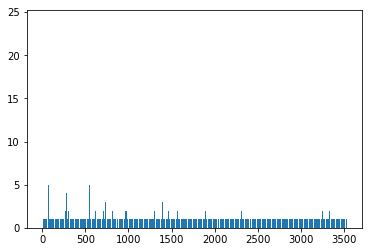

In [14]:
d = {}
for i in df_tags['tag']:
    if i not in d:
        d[i] = 1
    else:
        d[i] = d[i] + 1
plt.bar(range(len(d)), list(d.values()))
plt.show()


Above we created a pandas DataFrame from the tags dictionary. Then we created a basic pyplot bar graph to visualize frequency of tags. We will go into greater detail on this visualization using Tableau.

In [16]:
df_stats = pd.DataFrame(stats)
print(df_stats.info())
df_stats.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
comments    198 non-null float64
dislikes    200 non-null int64
likes       200 non-null int64
v_id        200 non-null object
views       200 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.9+ KB
None


,comments,dislikes,likes,v_id,views
0,116016.0,57794,704344,khPLWaBioOs,5633225
1,136188.0,3654,304136,t5_dSCu_mLY,2149645
2,2425.0,925,16742,r4VJ8o6yqzM,278730
3,818.0,137,10837,t5Lz14wu1uw,98721
4,3717.0,507,24526,UH0nTHb6OdY,250236


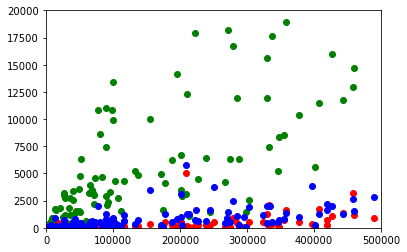

In [17]:
plt.plot(list(df_stats['views']), list(df_stats['likes']), 'go')
plt.plot(list(df_stats['views']), list(df_stats['dislikes']), 'ro')
plt.plot(list(df_stats['views']), list(df_stats['comments']), 'bo')
plt.axis([0,500000, 0,20000])
plt.show()

Above is the creation of the stats data frame from the statistics dictionary as well as a basic visualization in pyplot.

In [18]:
df_cd = pd.DataFrame(content_details)
print(df_cd.info())
df_cd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
caption       200 non-null bool
definition    200 non-null object
duration      200 non-null object
v_id          200 non-null object
dtypes: bool(1), object(3)
memory usage: 5.0+ KB
None


,caption,definition,duration,v_id
0,True,hd,PT2M57S,khPLWaBioOs
1,True,hd,PT5M56S,t5_dSCu_mLY
2,True,hd,PT7M55S,r4VJ8o6yqzM
3,True,hd,PT28S,t5Lz14wu1uw
4,True,hd,PT10M26S,UH0nTHb6OdY


In [19]:
df_channels = pd.DataFrame(channels)
print(df_channels.info())
df_channels.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
channel_id       200 non-null object
channel_title    200 non-null object
country          200 non-null object
num_videos       200 non-null int64
subscribers      200 non-null int64
dtypes: int64(2), object(3)
memory usage: 7.9+ KB
None


,channel_id,channel_title,country,num_videos,subscribers
0,UCj9DfRCLcjY9mFk29b2YyKw,The Scran Line,AU,325,356475
1,UCGGZ_POGmIWG1pQXTDzQv-g,Michelle Khare,US,60,645167
2,UCZYTClx2T1of7BRZ86-8fow,SciShow,,1432,4621411
3,UCsZsDjpf2Ppv_cT2K6_q2cw,Refinery29,,1191,724406
4,UCSrZ3UV4jOidv8ppoVuvW9Q,euronews (in English),,57217,344746


In [20]:
df_channels.sort_values(['num_videos'], ascending = False).head(5)

,channel_id,channel_title,country,num_videos,subscribers
122,UCupvZG-5ko_eiXAupbDfxWw,CNN,,138889,2499961
5,UCKy1dAqELo0zrOtPkf0eTMw,IGN,,124957,9034163
41,UC8p1vwvWtl6T73JiExfWs1g,CBS News,,58201,492232
4,UCSrZ3UV4jOidv8ppoVuvW9Q,euronews (in English),,57217,344746
189,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,US,40550,3008666


In [21]:
df_channels.sort_values(['subscribers'], ascending = False).head(5)

,channel_id,channel_title,country,num_videos,subscribers
96,UCBR8-60-B28hp2BmDPdntcQ,YouTube Spotlight,,268,26768376
55,UC20vb-R_px4CguHzzBPhoyQ,EminemVEVO,,69,24675063
167,UCRijo3ddMTht_IHyNSNXpNQ,Dude Perfect,US,168,24616136
32,UCp0hYYBW6IMayGgR-WeoCvQ,TheEllenShow,US,8155,21943853
63,UCSAUGyc_xA8uYzaIVG6MESQ,nigahiga,,325,20321580


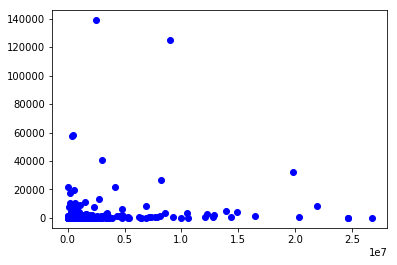

In [22]:
plt.plot(df_channels['subscribers'], df_channels['num_videos'], 'bo')
#plt.axis([0, 30000000,0,10000])
plt.show()

Below is the process to export our pandas dataframes into SQL. We form a connection to the kerr_h1 database in hadoop2.mathsci.denison.edu. Within the MySQL Workbench we created the empty tables by specifying each column and the data type for each. Primary keys were also identified within each table during this step. In order to avoid inserting duplicated data, there is a command to truncate (remove) all data that may be in the table before adding the information from the pandas dataframes.

In [24]:
import importlib
import keys
from sqlalchemy import create_engine, Table, MetaData

importlib.reload(keys)
keychain = keys.keychain

protocol = "mysql+mysqlconnector"
userid = keychain['MySQL']['userid']
userpass = keychain['MySQL']['userpass']
mysqlhost = "hadoop2.mathsci.denison.edu"
database = "kerr_h1"
connectionstring = "{}://{}:{}@{}/{}".format(protocol, userid, userpass, mysqlhost, database)
engine = create_engine(connectionstring)
metadata = MetaData()


In [25]:
snippet = Table('snippet', metadata, autoload = True, autoload_with = engine)
connection = engine.connect()

stmt = """TRUNCATE TABLE snippet"""
connection.execute(stmt)

stmt = """ INSERT INTO snippet (channel_id, channel_title, published_date, published_time, v_desc, v_id, v_title) 
VALUES ("{}", "{}", "{}", "{}", "{}", "{}", "{}")"""

for item in df_snippet.index:
    desc = df_snippet.loc[item]['v_desc']
    desc = desc.replace("\"","'")
    title = df_snippet.loc[item]['v_title']
    title = title.replace("\"","'")
    s = stmt.format(df_snippet.loc[item]['channel_id'], df_snippet.loc[item]['channel_title'], df_snippet.loc[item]['published_date'],df_snippet.loc[item]['published_time'], desc, df_snippet.loc[item]['v_id'], title)
    connection.execute(s)

In [26]:
tags = Table('tags', metadata, autoload = True, autoload_with = engine)
connection = engine.connect()

stmt = """TRUNCATE TABLE tags"""
connection.execute(stmt)

stmt = """ INSERT INTO tags (v_id, tag) 
VALUES ("{}", "{}")"""

for item in df_tags.index:
    tag = df_tags.loc[item]['tag']
    is_ascii = all(ord(char)<128 for char in tag)
    if is_ascii == True: 
        s = stmt.format(df_tags.loc[item]['v_id'], tag )
        connection.execute(s)

In [27]:
stats = Table('stats', metadata, autoload = True, autoload_with = engine)
connection = engine.connect()

stmt = """TRUNCATE TABLE stats"""
connection.execute(stmt)

stmt = """ INSERT INTO stats (comments, dislikes, likes, v_id, views) 
VALUES ({}, {}, {}, "{}", {})"""
df_stats = df_stats.where((pd.notnull(df_stats)), -1)

for item in df_stats.index:
    s = stmt.format(df_stats.loc[item]['comments'], df_stats.loc[item]['dislikes'], df_stats.loc[item]['likes'], df_stats.loc[item]['v_id'],df_stats.loc[item]['views'])
    connection.execute(s)

In [28]:
content_details = Table('content_details', metadata, autoload = True, autoload_with = engine)
connection = engine.connect()

stmt = """TRUNCATE TABLE content_details"""
connection.execute(stmt)

stmt = """ INSERT INTO content_details (caption, definition, duration, v_id) 
VALUES ({}, "{}", "{}", "{}")"""

for item in df_cd.index:
    s = stmt.format(df_cd.loc[item]['caption'], df_cd.loc[item]['definition'], df_cd.loc[item]['duration'], df_cd.loc[item]['v_id'])
    connection.execute(s)

In [29]:
channels = Table('channels', metadata, autoload = True, autoload_with = engine)
connection = engine.connect()

stmt = """TRUNCATE TABLE channels"""
connection.execute(stmt)

stmt = """ INSERT INTO channels (channel_id, channel_title, country, num_videos, subscribers) 
VALUES ("{}", "{}", "{}", {}, {})"""

for item in df_channels.index:
    s = stmt.format(df_channels.loc[item]['channel_id'], df_channels.loc[item]['channel_title'], df_channels.loc[item]['country'], df_channels.loc[item]['num_videos'], df_channels.loc[item]['subscribers'])
    connection.execute(s)